# Avis Restau ("Améliorez le produit IA de votre start-up")

La startup "Avis Restau" met en relation des clients et des restaurants afin d'améliorer les services fourni par les entreprises pour les clients et d'améliorer la visibilité des entreprises.

<img src="img/logo.png" width="500" style="center">

La startup souhaite améliorer sa plateforme avec une nouvelle foncitonnalitée de collaboration. Grace à celle-ci, les utilisateurs pourront, par exemple, poster des avis et des photos sur leurs restaurants préférés. Ce sera aussi l'occasion pour les entreprises de mieux comprendre les avis postés par les utilisateurs.

Le but de ce projet se résume ici par 2 objectifs principaux : 
 - La réalisation d'un algorithme de détection de sujet d'insatisfaction pour les commentaires laissés par les utilisateurs qui analyse les sujets principaux d'insatisfaction d'un client.
 - La réalisation d'un algorithme de classification des photos publiées par les utilisateurs sur un restaurant.

## Sommaire :

#### Partie général

- Présentation de l'ETL
- Présentation des données receuillies
- Présentation structure des jeux de données source
- Présentation générale des jeux de données source

#### Partie NLP ("Natural Language Processing")

- Présentation rapide des recherches
- Présentation du modèle final
- Test / résultat en application

#### Partie CV ("Computer Vision")

- Présentation rapide des recherches
- Présentation des modèles finaux
- Test / résultat en application sur les modèles finaux



# Partie général

Pour ce projet, il existe une grande banque de données disponible sur le site <a href="https://www.yelp.fr/">"Yelp"</a>, qui référence toutes sortes d'avis et photos dans le monde sur différentes entreprises/restaurants.

Yelp met à disposition une API pour récupérer les informations/commentaires sur les différentes entreprises disponibles sur leur site. Il met également à disposition une banque de données contenant des images labélisées et des informations et commentaires sur les différentes entreprises à <a href="https://www.yelp.com/dataset/download">télécharger ici</a>

J'ai donc d'abord créé un ETL ("Extract Transform and Load") pour recupérer les informations nécessaires via l'API fournit par  Yelp

## ETL

<img src="img/icon/database.png" width="200" style="center">

L'obtention des accès à l'API sont disponnibles sur <a href="https://www.yelp.com/developers">cette page</a>.

L'API fournit par Yelp, ne permet d'utiliser que 5000 requêtes mensuel, ce qui est largement suffisant dans notre contexte.

<img src="img/api_limit.jpg" width="600" style="center">

L'ETL est exécutable par un script python qui permet de récupérer les informations de différentes villes/états qui sont ensuite stockées dans le dossier "archive" avec la date de création. Ci-dessous un exemple du contenu récupérer par une exécution de l'ETL

Pour avoir une idée du contenu que renvoi l'API voici une image du retour de l'API :

<img src="img/api_postman.jpg" width="1000" style="center">

puis les données, une fois passées par l'ETL, sont chargées dans des fichiers csv.

## Données de l'API (traitées par l'ETL)

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

business = pd.read_csv("./archive/yelp_academic_dataset_business_1632329699.csv")
business.head(2)

,business_id,name,is_open,review_count,latitude,longitude,adress,city,postal_code,state,stars
0,V25xzPlcNAtnTi_xzQvr9g,Brassica,True,1174,39.976380,-83.002940,680 N High StNone,Columbus,43215,OH,4.5
1,2qwtLyomP0QHusZvDYMvEw,Hot Chicken Takeover,True,1275,39.971609,-83.004354,59 Spruce StNoneNorth Market,Columbus,43215,OH,4.5


In [2]:
review = pd.read_csv("./archive/yelp_academic_dataset_review_1632329699.csv")
review.head(2)

,review_id,business_id,user_id,text,stars,date
0,pNEMgQXoFreasJKjwmTgjg,V25xzPlcNAtnTi_xzQvr9g,AFsPcbupj3g4RfwuPFTXeA,this became one of my go-to places in Columbus...,5,2021-08-20 10:43:52
1,QKXjR9bYJmavbLXe9TDQqA,V25xzPlcNAtnTi_xzQvr9g,TYDUn6hXCQvJYP8Iofl-yQ,"Driving through Ohio, we were searching for a ...",5,2021-07-09 06:03:06


Le code source de cet ETL se situe dans le fichier `ETL.py` et utilise le fichier `list_city.txt` pour récupérer les différentes informations (présentées ci-dessus) des villes.

## Jeu de donnée sources

<img src="img/icon/server.png" width="200" style="center">

Yelp fournit un dataset très fourni. On y retrouve 6 fichiers (au format json dont un fichier de reviews contenant 8.000.000 commentaires) et un dossier de photos (200.000 photos)

Voici la strucutre des fichiers fournit :

<img src="img/structure_json_file.png" width="1000" style="center">

La structure contient des données qui ne sont pas nécessaire à notre analyse. 

Le fichier tip_dataset et checkin_dataset ne sont pas utiles pour notre problématique. Les fichiers principaux sont photos_dataset et review_dataset que l'on associ à leur business_dataset pour avoir des informations qui peuvent être intéressants, comme le type d'entreprise (car on cherche ici uniquement les entreprises de restauration ou de boisson) et la géolocalisation *(j'ai également ajouté le fichier user pour avoir des informations relatives sur le type de user que je n'ai finalement pas exploité)*

## Présentation des fichiers sources

<img src="img/icon/analysis.png" width="200" style="center">


Le fichier business_dataset comprend des informations sur le type d'entreprise, le nom, la géolocalisation, l'adresse, la note moyenne, les horaires d'ouverture.

Les informations sur le type d'entreprise m'a permis de filtrer les entreprises de restauration (rapide/restaurant/bar).
Les autres informations ne sont pas nécessaires pour notre contexte mais peuvent être intéressantes à exploiter pour d'autres problématiques (l'analyse exploratoire des jeux de données se situe dans le notebook `P06_analyse.ipynb`).

Grâce à ce premier filtre, j'ai éliminé les photos et commentaires n'appartenant pas à une entreprise de restauration.
Pour les fichiers photos et reviews, les informations se limitaient globalement aux photos (non de l'image dans le répertoire + ".jpg")

J'ai donc créé 2 nouveaux fichiers contenant uniquement les informations nécessaires à notre contexte.

In [3]:
review = pd.read_feather("./data/dataset_global/yelp_academic_final_dataset_review")
review.head(2)

,review_id,stars,text,date,name_business,complete_address,name_user,user_id
0,lWC-xP3rd6obsecCYsGZRg,4.0,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02,Prides Osteria,MA - (Beverly) :\n240 Rantoul St \nPostal code...,Mel,ak0TdVmGKo4pwqdJSTLwWw
1,8bFej1QE5LXp4O05qjGqXA,4.0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25,Target,MA - (Framingham) :\n400 Cochituate Rd \nPosta...,Brandon,YoVfDbnISlW0f7abNQACIg


In [4]:
photo = pd.read_feather("./data/dataset_global/yelp_academic_final_dataset_photo")
photo.head(2)

,photo_id,label,photo
0,Un_Og6jfhazVn7CxszkKEw,drink,./data/dataset_photo/photos/Un_Og6jfhazVn7Cxsz...
1,BFE1AFOs27scnnfeBf99ZA,drink,./data/dataset_photo/photos/BFE1AFOs27scnnfeBf...


Ces 2 fichiers contiennent les informations nécessaires pour les 2 objectifs, CV (Computer Vision) avec le fichier photo et NLP (Natural Language Processing)  avec le fichier reviews.

# NLP

## Recherches effectuées

<img src="img/icon/laptop.png" width="200" style="center">

J'ai structuré mes étapes de recherche comme suit:
- Nettoyage des documents
- Préparation des données vectorisation TFIDF et/ou BagOfWord
- Test de différentes approches (LSA / LDA)

En tout premier lieu, j'ai séparé les commentaires bons (supérieur à 3) et mauvais (inférieur à 3), pour ne garder que les mauvais commentaires soit environ 1.200.000 commentaires.

Voici la répartition des mots de ces 1.2M de commentaires mauvais (avec suppression des stop_word et lowercase) sous forme de nuage de mots (les mots les plus présents on une font-size plus importante):

<img src="img/wordcloud_all_bad_review_50word.png" width="600" style="center">

On retrouve les thèmes liées à la restauration comme "food drink, service, ice cream..."

J'ai donc commencé par nettoyer le jeu de données en utilisant la librairie "Spcay". Cette librairie permet de faciliter le traitement du language naturel. Voici un exemple ci-dessous de son implémentation pour retrouver les types d'entités présent dans un texte et les différentes dependances/tag :

In [7]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm",disable=["parser"])
r = nlp(review.iloc[42]["text"])
displacy.render(r,style='ent',jupyter=True)

In [8]:
displacy.render(r,style='dep',jupyter=True,options={'distance': 60})

Cette mise en application peut être intéressante notament sur le tag des différents types de token (pour identifier les verbes, adjectifs...). Cela permet de filtrer les informations utiles, par exemple les déterminants sont généralement assez peu intéressant pour identifier les différents topic. J'ai donc nettoyé le jeu de données et gardé uniquement les verbes, adjectifs, adverbes et noms communs.

In [9]:
import pickle
import function.function_nlp as fnct
from function.cleaner import cleaner_review

# Récupération du cleaner
open_cleaner = open("./data/pickle/new_cleaner_nlp.pkl","rb")
prepared_data = pickle.load(open_cleaner)
open_cleaner.close()

# attribution du label
def score_define(x):
    if x >= 4:
        return "good"
    elif x == 3:
        return "neutral"
    else:
        return "bad"
    
review["label"] = review["stars"].apply(lambda x: score_define(x))
bad_reviews = review[review["label"] == "bad"]["text"]

In [10]:
%%time
sample_bad_review = bad_reviews.sample(100000,random_state=42)
nlp = spacy.load("en_core_web_sm",disable=["parser","ner"])
data = [doc for doc in nlp.pipe(sample_bad_review,n_process=90,batch_size=2000)]

CPU times: user 2min 8s, sys: 30.8 s, total: 2min 38s
Wall time: 3min 54s


In [11]:
import gensim
nlp = spacy.load("en_core_web_sm")

def clean_data(doc,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'],):
    all_stopword = nlp.Defaults.stop_words
    return [token.lemma_ for token in doc if (token.pos_ in allowed_postags) and (not token.text in all_stopword)]

all_review_clean = [clean_data(doc) for doc in data]

bigram = gensim.models.Phrases(all_review_clean, min_count=2, threshold=80) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[all_review_clean],threshold=80)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_trigrams(all_doc):
    return [trigram_mod[doc] for doc in all_doc]

data_clean_trigram = make_trigrams(all_review_clean)

In [12]:
print("before :\n")
print(sample_bad_review.iloc[0])
print()
print("after :\n")
print(" ".join(data_clean_trigram[0]))

before :

I decided to meet someone here for coffee, and when I arrived, I needed to go to the bathroom.  But they are so tiny that they didn't have one, so they sent me across the street to the gift shop.  But the gift shop was closed, so I came back and asked where else I could go to the bathroom.  They told me to go to the library, so I walked all the way to the library, but that was also closed, so we wound up leaving.  Folks, this is not a good place to meet someone.  I have never heard of a coffee shop that didn't have a bathroom in it.  I also don't see how or why the place is called Bohemian.  Not only that, but there is hardly any seating.  Not a good experience, and I particularly didn't appreciate being sent on a wild goose chase just to go to the bathroom.

after :

decide meet coffee arrive need bathroom tiny send street gift_shop gift_shop closed come ask bathroom tell library walk way library close wound leave folk good place meet hear coffee shop bathroom place call har

Une fois les données nettoyées, on peut tester les différentes approches. J'ai d'abord essayé l'approche LDA avec le jeu de données nettoyé, et j'ai appliqué la vectorisation par "sac de mots" (Bag Of Word) qui donne une matrice des mots contenus dans chaque document.

J'ai recherché le meilleur nombre de topic avec l'algorithme de cohérence qui compare la distribution des topics par rapport au jeu de données et voici le résutlat :

<img src="img/coherence_model_lda.png" width="500" style="center">

J'ai donc essayé 10 et 11 topics. L'ensemble des tests réalisés sont dans le fichier `P06_nlp.ipynb`.

Voici un exemple du résultat de cette implémentation :

In [13]:
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary
import pyLDAvis.gensim
# Create Dictionary
id2word = Dictionary(data_clean_trigram)

# Create Corpus
texts = data_clean_trigram

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# LDA
ldamodel_10 = LdaMulticore(corpus=corpus,id2word=id2word,
                           num_topics=10, random_state=42,workers=60)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel_10, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.000268 -0.012298       1        1  18.445157
0     -0.006591 -0.001704       2        1  15.176967
2     -0.006819  0.006812       3        1  11.311161
5     -0.000842 -0.003601       4        1  10.891537
3     -0.011029  0.002686       5        1   9.768538
9     -0.005152 -0.000262       6        1   9.257949
6     -0.002736  0.001415       7        1   8.036072
1      0.015262  0.020188       8        1   7.486523
7     -0.004387 -0.001933       9        1   6.168432
8      0.022025 -0.011304      10        1   3.457665, topic_info=       Term          Freq         Total Category  logprob  loglift
38     food  83756.000000  83756.000000  Default  30.0000  30.0000
23    place  57256.000000  57256.000000  Default  29.0000  29.0000
14     good  52358.000000  52358.000000  Default  28.0000  28.0000
145  minute  26598.000000  26598.000000  Default  27.0000  27.0000
2       ask  33315.000000  33315.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
267    wait    734.282919  34844.747071  Topic10  -5.4343  -0.4952
124     sit    601.885734  14622.476307  Topic10  -5.6331   0.1743
243     say    636.469048  29019.670409  Topic10  -5.5772  -0.4552
100    look    616.775268  21336.173373  Topic10  -5.6086  -0.1791
201   great    608.907956  18364.998793  Topic10  -5.6215  -0.0420

[864 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
29235      8  0.818213    -felt
41782      7  0.362488  -nobody
21944      3  0.490167   -waite
21944      7  0.163389   -waite
21944     10  0.163389   -waite
...      ...       ...      ...
320        7  0.055966     year
320        8  0.072617     year
320        9  0.045328     year
320       10  0.016651     year
43106      8  0.818206   ~we're

[2429 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 6, 4, 10, 7, 2, 8, 9])

Ce graphique représente sur le un plan 2D la répartition des topics et sur chaque topic selectionné on voit la répartition des mots du topic par rapport au jeu de données global (sur la partie gauche).

On remarque ici qu'il est difficile d'interpréter les résutlats (les mots dominants de chaque topic sont proches entre chaque topic). 

Avec d'autres nombres de topic et même avec une vectorisation par TF-IDF, il est toujours difficile d'interpréter les résultats. Je me suis donc dirigé vers une approche de réduction de dimension par LSA (Latent Semantic Allocation) grâce à la factorisation SVD tronqué proposé par Sklearn (TruncatedSVD) 

## Modélisation finale

<img src="img/icon/book.png" width="200" style="center">

Le modèle final est une réduction de dimension LSA avec 19 composantes (choix effectué manuellement pour trouver le nombre de composante qui fournissent des sujet intéressant). On retrouve plusieurs catégories intéressantes liées à l'attente des clients, la nourriture, le prix, la livraison... Cela permet d'avoir une idée des commentaires écrit et des catégories/topics.

Le modèle permet de connaître le pourcentage de chaque catégorie/topic pour un document donné en voici un exemple :

In [14]:
open_lsa_model = open("./data/pickle/lsa_model","rb")
best_model = pickle.load(open_lsa_model)
open_lsa_model.close()

 Voici le résutlat des différents topics :

In [15]:
for index,topic in enumerate(best_model.components_):
    print("Topic #"+str(index))
    print(" ".join([prepared_data["tfidfvectorizer"].get_feature_names_out()[i] for i in topic.argsort()[-15:]]))
    print()

Topic #0
restaurant bad table ask get go minute wait good service come time place order food

Topic #1
min customer take order manager drink sit seat hour say ask tell table minute wait

Topic #2
sauce pick topping hour deliver say tell slice phone crust cheese call delivery order pizza

Topic #3
take meal say sauce ask come salad get sandwich rice minute burger fry chicken order

Topic #4
min time cold take horrible delivery terrible hour slow minute bad wait order service food

Topic #5
restaurant food waiter bar waitress good sit come server seat drink minute wait table pizza

Topic #6
location people hour good drive coffee long sandwich time line fry minute place wait burger

Topic #7
terrible cheese take waitress bartender server come ask bar beer fry order service drink burger

Topic #8
hour coffee menu time delivery sushi bartender price food good beer bar place drink order

Topic #9
location terrible wait taste customer bartender bad slow minute bar sandwich service coffee drin

In [16]:
review_test = 40
test = bad_reviews.iloc[review_test]
print(test)
data = prepared_data.transform([test])
pred = best_model.transform(data)
print("Prediction :")
fnct.prediction(pred,global_dic=False)

The food has always been good, always. The service on he other hand has always always been bad. The waiters always leave you hanging, the owner is rude and, sad to say, ghetto in front of customers. Again, the food is spot on but the service is horrible. I have been coming here for years and it never changes. We are here today, the first time in a couple months and they have renovated. They have expanded into the unit next door. Good renovation, bigger space, better decor. Still a ways to go before it is finished but good. Wish the service was better, unfortunately I doubt I will return. I think today was it.
Prediction :


{'Insatisfaction général': 0.2572891709833348,
 'Service lent': 0.10595465133225275,
 'Réservation / horaire': 0.08563629142422625,
 'Boisson & sushi': 0.04217985186837905,
 'Service lent & prix': 0.04009848072954432,
 'Prix / Poisson': 0.026365219875696982,
 'Chinois / Poisoon': 0.010871242519745646,
 'Attente & Service': -0.01789599154293413,
 'Sale, & service & petit dej': -0.02460866710127946,
 'Nourriture & boisson': -0.03534874998267021,
 'Bar/boisson & prix': -0.04287341428953683,
 'petit dej': -0.06458530219710001,
 'Attente & boisson & prix': -0.06477792796745124,
 'Livraison / commande pizza': -0.07588251363642774,
 'Service mauvais': -0.08516389437809072,
 'Restauration rapide': -0.13629737160041355}

In [17]:
test = "it took about 15 minutes to come out. Horrible service im waiting 15 minute seating on my chair to get my meal!"
print(test)
data = prepared_data.transform([test])
pred = best_model.transform(data)
print("Prediction :")
fnct.prediction(pred,global_dic=False)

it took about 15 minutes to come out. Horrible service im waiting 15 minute seating on my chair to get my meal!
Prediction :


{'Service lent': 0.3300260273558596,
 'Insatisfaction général': 0.22436562874273136,
 'Attente & Service': 0.1936834930365597,
 'Service mauvais': 0.15634713796734218,
 'Prix / Poisson': 0.14142963378361845,
 'Nourriture & boisson': 0.0735822370954154,
 'Service lent & prix': 0.04157893843710679,
 'Chinois / Poisoon': 0.035235047718090926,
 'petit dej': 0.017618191136840437,
 'Bar/boisson & prix': -0.01853710895404955,
 'Boisson & sushi': -0.025224418144588166,
 'Réservation / horaire': -0.026403613763141386,
 'Sale, & service & petit dej': -0.02669639929703443,
 'Restauration rapide': -0.03075528165179034,
 'Livraison / commande pizza': -0.03350996816028148,
 'Attente & boisson & prix': -0.09080276048693765}

In [18]:
test = "it took about 15 minutes to come out. Horrible service im waiting 15 minute seating on my chair to get my meal!"
print(test)
data = prepared_data.transform([test])
pred = best_model.transform(data)
print("Prediction :")
fnct.prediction(pred,global_dic=True)

it took about 15 minutes to come out. Horrible service im waiting 15 minute seating on my chair to get my meal!
Prediction :


{'Attente & Service': 0.6964111786522802,
 'Insatisfaction général': 0.22436562874273136,
 'Prix': 0.14142963378361845,
 'Nourriture & boisson': 0.04282695544362506,
 'Chinois / Poisoon': 0.035235047718090926,
 'petit dej': 0.017618191136840437,
 'Bar/boisson & prix': -0.01853710895404955,
 'Réservation / horaire': -0.026403613763141386,
 'Sale': -0.02669639929703443,
 'Livraison / commande pizza': -0.03350996816028148,
 'Attente & boisson & prix': -0.09080276048693765}

On voit que globalement les catégories sont bien définies et que les catégories dominantes sont bien identifiées.

Ce modèle peut être amélioré avec l'entraînement sur la totalité des données ainsi qu'une recherche plus approfondi des vrais sujets et le nombre de composantes.

# CV

## Recherches effectuées

<img src="img/icon/artificial.png" width="200" style="center">

J'ai structuré mes étapes de recherche comme suit:
- Classification grâce à SIFT + KMeans faisabilité
- Si valide appliquer
- Approche CNN "transfert learning"
- Approche CNN "from scratch" (manuel)

La première chose que j'ai effectué était donc la méthode SIFT qui permet de créer des descripteurs (pour faire simple, SIFT se base sur le contraste de couleur de pixel pour détecter les bords des images qu'il qualifie comme descripteur)

Voici une représentation de cet algorithme (les points de couleur sont des descripteurs détectés par l'algorithme SIFT):

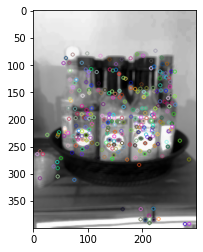

Descripteurs :  (321, 128)

[[53. 13.  0. ...  0.  0.  0.]
 [12.  5.  1. ...  0.  0.  0.]
 [20. 14. 11. ...  2.  0.  0.]
 ...
 [12. 18.  0. ...  0. 16. 74.]
 [10. 20. 94. ...  0.  0.  0.]
 [34. 61. 24. ...  0.  0.  0.]]


In [19]:
import cv2
import matplotlib.pyplot as plt
import function.function_cv as fnct_cv

path = photo.iloc[1]["photo"]

kp,des=fnct_cv.transform_image(path)

image=fnct_cv.get_transform_image(path)

img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()

print("Descripteurs : ", des.shape)
print()
print(des)

### Classification avec méthode SIFT 

J'ai donc essayé avec cette approche de voir si il était possible de bien distinguer les différentes classes qui sont :
- drink
- food
- menu
- interior
- outside

J'ai donc effectué le sift sur un échantillon de 2500 images et j'ai appliqué une réduction de dimension PCA (99% de variance conservé pour garder le maximum de variance tout en réduisant le temps de calcul) et ensuite une réduction T-SNE pour visualiser le jeu de données en 2 dimensions qui donne le résutlat suivant :

<img src="img/tsne_photo_sample.png" width="800" style="center">

On voit ici que les différentes classes se distinguent suffisament. Par exemple "menu" est totalement bien séparé des autres classses. On retrouve au centre plus vers la droite les images "interior" et "outside", et sur la partie tout à gauche "drink" et "food" (plus sur la partie haute gauche).

Cela peut sembler cohérent avec une réduction de dimension aussi importante. Les descripteurs similaires se rejoignent mais des distinctions semblent visibles.

Après clustering de ces données à base dimension on obtien un score de 0.15 ARI score par rapport au classe initial, ce score est assez bas mais est du entre autre à cette réduction de dimension.

Il est donc possible de créer un autoclassifier qui peut classifier, assez efficacement, les classe "menu" puis "interior/outside" et "drink/food". 

### Modélisation finale SIFT

Comme nous avons ici un jeu de données labélisé, j'ai effectuer une modélisation avec l'algorithme SIFT pour créer un classifier afin de labéliser les nouvelle images d'utilisateur.

J'ai donc ensuite appliqué un algorithme de classificaiton sur les descripteurs sans réduction de dimension pour conserver un maximum de correspondance avec l'image réelle et augmenté le score final du modèle (quitte à augmenter le temps de calcul). Le modèle utilisé a suivi donc le processus suivant :
- récupération des descripteurs (SIFT)
- Clustering de l'ensemble des descripteurs pour avoir une correspondance des descripteurs similaires
- Création d'un "Bag Of Visual Word" (BOVW) par rapport au cluster de descripteur pour chaque image
- Classificiation grâce au BOVW

Voici le résutlat du modèle final (matrice de confusion): 

<img src="img/SIFT_confusion_matrix.jpg" width="400" style="center">

On obtient grâce à ce modèle une accuracy de 0.6. Ce modèle est perfectible car n'a été entrainé que sur 10000 photos (1/10 du jeu de données)

voici un exemple de classification :

In [20]:
import pickle
open_classifier = open("./data/pickle/classifier_cv_sift","rb")
best_model = pickle.load(open_classifier)
open_classifier.close()

vrai classe :  drink


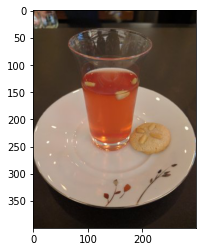


Prediction : ['drink']
Classement :
#drink : 67.87%
#outside : 11.58%
#food : 10.43%
#interior : 7.16%
#menu : 2.96%
CPU times: user 4.57 s, sys: 3.64 s, total: 8.21 s
Wall time: 603 ms


In [21]:
%%time
photo_n= 10000
path = photo.iloc[photo_n]["photo"]
label = photo.iloc[photo_n]["label"]
X_pred = fnct_cv.preprocess_1_image(path)
print("vrai classe : ",label)
img = plt.imread(path)
plt.imshow(img)
plt.show()
print()
print("Prediction :",best_model.predict(X_pred))
print("Classement :")
fnct_cv.get_classement_classifier_linear(best_model,X_pred)

## Modélisation finale CNN (Convolutional Neural Network ou Réseau Neuronal Convolutif) 

<img src="img/icon/eye.png" width="200" style="center">

Cette approche par réseau de neurones convolutif est très populaire par leur approche de couche convolutive dans le traitement des images. Cette méthode permet de "réduire la taille des images" à l'aide de filtres et de features map.

Pour cette approche j'ai essayé 2 choses : 
- La création d'un CNN en partant de 0
- L'implémentation d'un CNN existant en modifiant les dernières couches pour l'adapter à notre contexte ("transfert learning")

Le CNN de 0 est assez peu convaincant, je passerais rapidement dessus car il nécessiterait bien plus d'attention/optimisation et entraînement pour atteindre le niveau du CNN par "transfert learning". Encore une fois les détails sont dans le fichiers `P06_computer_vision.ipynb` 

Les résutlat du CNN par transfert learning sont assez impressionnants : en seulement 5 minutes d'entraînement, sur 2000 images, l'accuracy est de 90%  sur la classification d'image !

<img src="img/CNN_confusion_matrix.jpg" width="600" style="center">

Les erreurs présentent semble pouvoir être légitime. Par exemple, une image de boisson où est présente majoritairement de la nourriture, l'algorithme peut bien évidemment penser (à juste titre) que la photo est à labéliser en nourriture au lieu de boisson.

Comme nous l'avons vu dans l'étape de recherches les erreurs les plus communes semblent être entre nourriture/boisson et entre intérieur/extérieur.


In [23]:
import tensorflow as tf
from tensorflow import keras
transfert = keras.models.load_model('./data/model/vgg16_transfert_learning')

vrais classe : drink


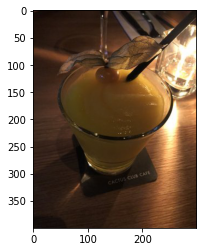

Prediction : drink
Classement :
#drink : 100.0%
#outside : 0.0%
#food : 0.0%
#interior : 0.0%
#menu : 0.0%


In [25]:
import matplotlib.pyplot as plt

photo_n= 8888
path = photo.iloc[photo_n]["photo"]
label = photo.iloc[photo_n]["label"]
image = fnct_cv.get_image_preprocess(path)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
print("vrais classe :",label)
img = plt.imread(path)
plt.imshow(img)
plt.show()

prediction = transfert.predict(image)
label = prediction.argsort()[0][4] # argsort tri du plus petit au plus grand, la dernière est donc la prédiction la plus grande
label = fnct_cv.get_label(label)
print("Prediction :",label)
print("Classement :")
fnct_cv.get_classement(prediction)

Comparatif avec le modèle classification SIFT :

vrai classe :  drink


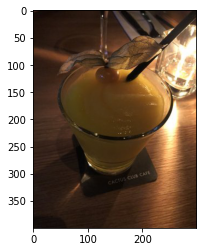


Prediction : ['drink']
Classement :
#drink : 56.46%
#food : 26.15%
#interior : 7.0%
#outside : 6.94%
#menu : 3.44%


In [26]:
X_pred = fnct_cv.preprocess_1_image(path)
print("vrai classe : ",label)
img = plt.imread(path)
plt.imshow(img)
plt.show()
print()
print("Prediction :",best_model.predict(X_pred))
print("Classement :")
fnct_cv.get_classement_classifier_linear(best_model,X_pred)

# Conclusion

<img src="img/icon/clock.png" width="200" style="center">

Pour la partie classification d'image il serait donc plus logique de partir sur le CNN en transfert learning que l'on peut encore améliorer. Pour la partie identification des sujets d'insatisfactions, la méthode est perfectible, on trouve des topics intéressant mais qui peuvent être ajustés certainement.

<div>Icons made by <a href="https://www.flaticon.com/authors/flatart-icons" title="flatart_icons">flatart_icons</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a></div>

Référence : 

- CV :  https://nbviewer.org/urls/s3-eu-west-1.amazonaws.com/course.oc-static.com/projects/Webinars/Data/AI_Avril_2021/Weather_first_analysis_V1.0.ipynb (Oliver Chotin)

- NLP : https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05 (Joyce Xu https://medium.com/@joycex99)

- CNN : https://www.udemy.com/course/le-deep-learning-de-a-a-z/ (Hadelin de Ponteves https://www.udemy.com/user/hadelin-de-ponteves/)